# Importing necessary libraries

In [1]:
import pandas as pd
import re
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

from scipy.stats import pointbiserialr
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from IPython.display import clear_output

2025-06-20 14:29:37.619359: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750429777.832940      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750429777.895206      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Loading and preprocessing the dataset

In [2]:
# Set the image directory
img_dir = '/kaggle/input/utkface-new/UTKFace'

# List all image file paths
image_files = [os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.endswith('.jpg')]

# Parse attributes from filenames and store in a DataFrame
def parse_filename(filename):
    basename = os.path.basename(filename)
    match = re.match(r'(\d+)_(\d)_(\d)_.*\.jpg', basename)
    if match:
        age = int(match.group(1))
        gender = int(match.group(2))
        race = int(match.group(3))
        return age, gender, race
    else:
        return None, None, None

# Build a list of parsed data
parsed_data = [parse_filename(f) + (f,) for f in image_files if parse_filename(f)[0] is not None]

# Convert to DataFrame
df = pd.DataFrame(parsed_data, columns=['age', 'gender', 'race', 'file_path'])

# Remove NA
df = df.dropna().reset_index(drop=True)

# Split into train/val/test (e.g., 80/10/10 split)
train_df, val_test_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['gender']
)
val_df, test_df = train_test_split(
    val_test_df, test_size=0.5, random_state=42, stratify=val_test_df['gender']
)

# Extract file paths
train_files = train_df['file_path'].tolist()
val_files = val_df['file_path'].tolist()
test_files = test_df['file_path'].tolist()

# Preprocessing the images
def load_and_preprocess_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)  # Normalize to [0, 1]
    img = tf.image.resize(img, [64, 64])
    return img

batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices(train_files)
train_dataset = train_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices(val_files)
val_dataset = val_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices(test_files)
test_dataset = test_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

I0000 00:00:1750429868.175224      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750429868.176047      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


# Define the sampling layer and β-VAE

In [3]:
latent_dim = 32

# Sampling layer
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


# Seed to ensure reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Beta-VAE architecture
beta = 2  # Hyperparameter for KL-divergence weight
class BetaVAE(Model):
    def __init__(self, encoder, decoder, beta):
        super(BetaVAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta
        self.sampling = Sampling() 

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = self.sampling([z_mean, z_log_var])
        reconstructed = self.decoder(z)
        return reconstructed

    def train_step(self, data):
        # Perform the forward pass and compute losses
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampling([z_mean, z_log_var])
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(
                tf.keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
            ))
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            total_loss = reconstruction_loss + self.beta * kl_loss

        # Apply gradients
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss
        }

    def test_step(self, data):
        # Forward pass
        z_mean, z_log_var = self.encoder(data)
        z = self.sampling([z_mean, z_log_var])
        reconstruction = self.decoder(z)
        
        # Compute losses
        reconstruction_loss = tf.reduce_mean(tf.reduce_sum(
            tf.keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
        ))
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )
        total_loss = reconstruction_loss + self.beta * kl_loss
    
        # Return the computed losses
        return {
        "loss": total_loss,
        "reconstruction_loss": reconstruction_loss,
        "kl_loss": kl_loss
    }

# Loading a previously trained and saved autoencoder (to save time and skip the training process)

In [4]:
# Loading the encoder and decoder
encoder = tf.keras.models.load_model('/kaggle/input/utkface-autoencoders/encoder_arch.h5') #Loading the encoder model
decoder = tf.keras.models.load_model('/kaggle/input/utkface-autoencoders/decoder_arch.h5') #Loading the decoder model
vae = BetaVAE(encoder, decoder, beta)

vae.get_layer('encoder').load_weights('/kaggle/input/utkface-autoencoders/encoder.weights.h5') 
vae.get_layer('decoder').load_weights('/kaggle/input/utkface-autoencoders/decoder.weights.h5')

encoder.summary()
decoder.summary()
vae(tf.keras.Input(shape=(64, 64, 3)))
vae.summary()

# Storing the weights of the first layer of the decoder for usage after rotation of latent space
W, bias = decoder.layers[1].get_weights()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 32)     │          1,568 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 16, 16, 64)     │         32,832 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 8, 8, 128)      │        131,200 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 8192)           │              0 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 256)            │      2,097,408 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 32)             │          8,224 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 32)             │          8,224 │ dense_2[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,279,456 (8.70 MB)

 Trainable params: 2,279,456 (8.70 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8192)                │         270,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 16, 16, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 32, 32, 64)          │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_6 (Conv2DTranspose) │ (None, 64, 64, 32)          │          32,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_7 (Conv2DTranspose) │ (None, 64, 64, 3)           │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 697,411 (2.66 MB)

 Trainable params: 697,411 (2.66 MB)

 Non-trainable params: 0 (0.00 B)

Model: "beta_vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder (Functional)                 │ ((None, 32), (None, 32))    │       2,279,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (None, 64, 64, 3)           │         697,411 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sampling (Sampling)                  │ ?                           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,976,867 (11.36 MB)

 Trainable params: 2,976,867 (11.36 MB)

 Non-trainable params: 0 (0.00 B)

# Define the encoder and decoder structure (Not required if a previously trained and saved autoencoder is loaded before)

In [12]:
# Encoder
def build_encoder():
    inputs = layers.Input(shape=(64, 64, 3))
    x = layers.Conv2D(32, 4, strides=2, activation='relu', padding='same')(inputs)
    x = layers.Conv2D(64, 4, strides=2, activation='relu', padding='same')(x)
    x = layers.Conv2D(128, 4, strides=2, activation='relu', padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    z_mean = layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
    return Model(inputs, [z_mean, z_log_var], name='encoder')


# Decoder
def build_decoder():
    inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(8 * 8 * 128, activation='relu')(inputs)
    x = layers.Reshape((8, 8, 128))(x)
    x = layers.Conv2DTranspose(128, 4, strides=2, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(64, 4, strides=2, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(32, 4, strides=2, activation='relu', padding='same')(x)
    outputs = layers.Conv2DTranspose(3, 3, activation='sigmoid', padding='same')(x)
    return Model(inputs, outputs, name='decoder')

# Instantiate the model
encoder = build_encoder()
decoder = build_decoder()
vae = BetaVAE(encoder, decoder, beta)
vae(tf.keras.Input(shape=(64, 64, 3)))
vae.compile(optimizer=tf.keras.optimizers.Adam())

encoder.summary()
decoder.summary()
vae.summary()

# Training and saving the autoencoder (Not required if a previously trained and saved autoencoder is loaded before)

In [13]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model
epochs = 50
history = vae.fit(train_dataset, validation_data = test_dataset, epochs=epochs)

# Save the model
vae.get_layer('encoder').save_weights('encoder.weights.h5')
vae.get_layer('decoder').save_weights('decoder.weights.h5')
vae.get_layer('encoder').save('encoder_arch.h5') 
vae.get_layer('decoder').save('decoder_arch.h5')

# Storing the weights of the first layer of the decoder for usage after rotation of latent space
W, bias = decoder.layers[1].get_weights()

Epoch 1/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - kl_loss: 11.4700 - loss: 2554.2434 - reconstruction_loss: 2531.3035 - val_kl_loss: 16.9330 - val_loss: 2520.4807 - val_reconstruction_loss: 2486.6147
Epoch 2/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - kl_loss: 17.4915 - loss: 2441.4927 - reconstruction_loss: 2406.5098 - val_kl_loss: 16.5757 - val_loss: 2498.7856 - val_reconstruction_loss: 2465.6343
Epoch 3/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - kl_loss: 17.9825 - loss: 2426.9404 - reconstruction_loss: 2390.9756 - val_kl_loss: 16.5595 - val_loss: 2493.3848 - val_reconstruction_loss: 2460.2656
Epoch 4/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - kl_loss: 18.4307 - loss: 2421.4275 - reconstruction_loss: 2384.5662 - val_kl_loss: 17.9492 - val_loss: 2486.7021 - val_reconstruction_loss: 2450.8037
Epoch 5/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - kl_loss: 18.7833 - loss: 2418.1086 - reconstruction_loss: 2380.5420 - val_kl_loss: 18.2255 - val_loss: 2491.6211 - val_recon

# Evaluate and visualize

I0000 00:00:1750364484.235351      35 cuda_dnn.cc:529] Loaded cuDNN version 90300


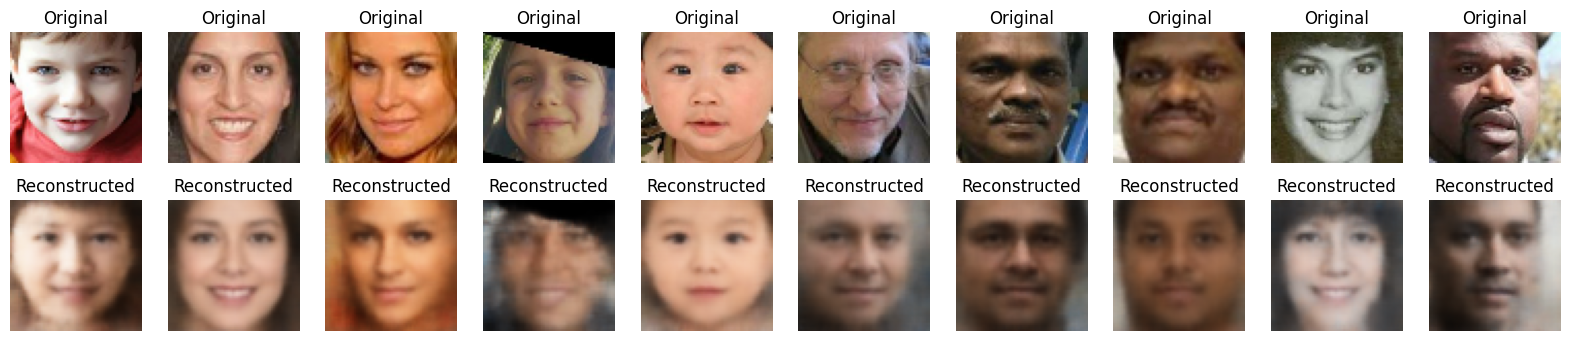

In [5]:
# Fetch a batch of test images
test_images = next(iter(test_dataset))  # Extract a batch of images (10 in this case)

# Reconstruct images
encoded_means, encoded_log_vars = encoder(test_images)
latent_vectors = Sampling()([encoded_means, encoded_log_vars])
reconstructed_images = decoder(latent_vectors)

# Visualize original and reconstructed images
plt.figure(figsize=(20, 4))
for i in range(10):
    # Original images
    plt.subplot(2, 10, i + 1)
    plt.imshow(test_images[i].numpy())
    plt.title("Original")
    plt.axis('off')
    
    # Reconstructed images
    plt.subplot(2, 10, i + 11)
    plt.imshow(reconstructed_images[i].numpy())
    plt.title("Reconstructed")
    plt.axis('off')

plt.show()

# Loading attribute data

In [5]:
train_first_attribute, val_first_attribute = train_df['gender'][:18944], val_df['gender'][:2368] 
train_second_attribute, val_second_attribute = (train_df['age'][:18944]< 30).astype(int), (val_df['age'][:2368]< 30).astype(int)

# Extracting the latent space representation

In [6]:
def sample_latent_space(encoder, dataset, seed=None):

    all_latent_vectors = []
    
    if seed is not None:
        np.random.seed(seed)
        
    for batch in dataset:
        means, log_vars = encoder(batch)
        latent_vectors = Sampling()([means, log_vars])
        all_latent_vectors.append(latent_vectors)
    
    all_latent_vectors = tf.concat(all_latent_vectors, axis=0).numpy()
    return all_latent_vectors


latent_train = sample_latent_space(encoder,train_dataset,42)  # Extract latent space for train set
latent_val = sample_latent_space(encoder, val_dataset, 42)  # Extract latent space for test set

I0000 00:00:1750429893.507167      35 cuda_dnn.cc:529] Loaded cuDNN version 90300


# Applying factor rotation to the latent space representation

In [7]:
Z_train, Z_val, y_train, y_val, y_train_2, y_val_2 = latent_train, latent_val, train_first_attribute, val_first_attribute, train_second_attribute, val_second_attribute

logistic_model = LogisticRegression()
logistic_model.fit(Z_train, y_train)

beta_1 = logistic_model.coef_.flatten()  # Coefficients from the logistic model for first attribute
beta_1 = beta_1 / np.linalg.norm(beta_1)

logistic_model_2 = LogisticRegression()
logistic_model_2.fit(Z_train, y_train_2)

beta_2 = logistic_model_2.coef_.flatten()  # Coefficients from the logistic model for second attribute
beta_2 = beta_2 / np.linalg.norm(beta_2)

I_n = np.eye(Z_train.shape[1])  # Identity matrix of size n x n; n = latent dimension
B = np.column_stack((beta_1, beta_2, I_n[:, 2:]))
Q, _ = np.linalg.qr(B)
R = Q # The orthogonal rotation matrix

# Oblique rotation of the latent space based on chosen attributes
R_prime = np.column_stack((beta_1, beta_2, Q[:, 2:]))

# Apply the rotation
Z_train_orth_rotated = Z_train @ R
Z_val_orth_rotated = Z_val @ R

Z_train_obl_rotated = Z_train @ R_prime
Z_val_obl_rotated = Z_val @ R_prime

# Disentanglement metrics

In [8]:
def predictability_matrix(Z, attrs):
    """
    Z: latent space (sample_size, n)
    attrs: binary attributes (sample_size, k)
    Returns: (k, n) matrix of ROC AUC scores
    """
    k = attrs.shape[1]
    n = Z.shape[1]
    scores = np.zeros((k, n))
    for i in range(k):
        attr = attrs[:, i]
        for j in range(n):
            clf = LogisticRegression(max_iter=200)
            clf.fit(Z[:, j:j+1], attr)
            prob = clf.predict_proba(Z[:, j:j+1])[:, 1]
            scores[i, j] = roc_auc_score(attr, prob)
    return scores


def compute_sap(Z, attrs):
    """
    Z: latent space (sample_size, n)
    attrs: binary attributes (sample_size, k)
    Returns: average SAP score
    """
    k = attrs.shape[1]
    n = Z.shape[1]
    sap_values = []
    for i in range(k):
        attr = attrs[:, i]
        aucs = []
        for j in range(n):
            clf = LogisticRegression(max_iter=200)
            clf.fit(Z[:, j:j+1], attr)
            prob = clf.predict_proba(Z[:, j:j+1])[:, 1]
            auc = roc_auc_score(attr, prob)
            aucs.append(auc)
        aucs = np.sort(aucs)[::-1]
        sap_values.append(aucs[0] - aucs[1])
    return np.mean(sap_values)

def compute_mutual_info_matrix(Z, attrs):
    """
    Z: latent space (sample_size, n)
    attrs: binary attributes (sample_size, k)
    Returns: (k, n) matrix of MI scores
    """
    k = attrs.shape[1]
    n = Z.shape[1]
    mi_scores = np.zeros((k, n))
    for i in range(k):
        mi = mutual_info_classif(Z, attrs[:, i], discrete_features=False)
        mi_scores[i] = mi
    return mi_scores


def compute_modularity(mi_matrix):
    """
    Compute the modularity score for a latent code given the mutual information matrix.

    Parameters:
    -----------
    mi_matrix : np.ndarray of shape (k, n)
        Mutual information matrix between each attribute (k) and each latent dimension (n).
        mi_matrix[i, j] = mutual information between attribute i and latent dimension j.

    Returns:
    --------
    modularity : float
        The average modularity score over all latent dimensions, in [0, 1].
    """

    k, n = mi_matrix.shape
    modularity_scores = []

    for j in range(n):
        mi_vec = mi_matrix[:,j]
        theta_j = np.max(mi_vec)
        if theta_j == 0:
            # If no mutual info, modularity is undefined; consider it zero modularity
            modularity_scores.append(0.0)
            continue

        # Construct template vector: theta_j at the max factor index, 0 elsewhere
        template = np.zeros(k)
        max_idx = np.argmax(mi_vec)
        template[max_idx] = theta_j

        # Compute deviation δ_j
        numerator = np.sum((mi_vec - template) ** 2)
        denominator = (theta_j ** 2) * (k - 1)
        delta_j = numerator / denominator if denominator > 0 else 0

        # Modularity for dimension j
        modularity_j = 1 - delta_j
        modularity_scores.append(modularity_j)

    # Average modularity over all latent dimensions
    return np.mean(modularity_scores)

# Evaluate disentanglement metrics

In [11]:
attrs = np.stack([y_train, y_train_2], axis=1)

# Before and after rotation
print("Predictability Matrix")
scores_orig = predictability_matrix(Z_train[:,:2], attrs)
print("Before rotation")
print(scores_orig)
scores_orth_rot = predictability_matrix(Z_train_orth_rotated[:,:2], attrs)
print("After orthogonal rotation")
print(scores_orth_rot)
scores_obl_rot = predictability_matrix(Z_train_obl_rotated[:,:2], attrs)
print("After oblique rotation")
print(scores_obl_rot)
print("\n")

print("Mutual info matrix")
mig_orig = compute_mutual_info_matrix(Z_train[:,:2], attrs)
print("Before rotation")
print(mig_orig)
mig_orth_rot = compute_mutual_info_matrix(Z_train_orth_rotated[:,:2], attrs)
print("After orthogonal rotation")
print(mig_orth_rot)
mig_obl_rot = compute_mutual_info_matrix(Z_train_obl_rotated[:,:2], attrs)
print("After oblique rotation")
print(mig_obl_rot)

print("\n")
mod_orig = compute_modularity(mig_orig)
print(f"Modularity before rotation: {mod_orig}")
mod_orth_rot = compute_modularity(mig_orth_rot)
print(f"Modularity after orthogonal rotation:  {mod_orth_rot}")
mod_obl_rot = compute_modularity(mig_obl_rot)
print(f"Modularity after oblique rotation:  {mod_obl_rot}")
print("\n")

print("SAP score")
sap_orig = compute_sap(Z_train[:,:2], attrs)
print("Before rotation")
print(sap_orig)
sap_orth_rot = compute_sap(Z_train_orth_rotated[:,:2], attrs)
print("After orthogonal rotation")
print(sap_orth_rot)
sap_obl_rot = compute_sap(Z_train_obl_rotated[:,:2], attrs)
print("After oblique rotation")
print(sap_obl_rot)
print("\n")

Predictability Matrix
Before rotation
[[0.5416291  0.52549084]
 [0.49819585 0.52405933]]
After orthogonal rotation
[[0.80255905 0.5090515 ]
 [0.64093    0.69888716]]
After oblique rotation
[[0.80255905 0.67309447]
 [0.64093    0.75067016]]


Mutual info matrix
Before rotation
[[0.00122583 0.00363099]
 [0.00269634 0.00389511]]
After orthogonal rotation
[[0.15171466 0.        ]
 [0.03405015 0.06837039]]
After oblique rotation
[[0.15171466 0.0525293 ]
 [0.03405015 0.10536721]]


Modularity before rotation: 0.46216454505288584
Modularity after orthogonal rotation:  0.9748143653985911
Modularity after oblique rotation:  0.8505455005423468


SAP score
Before rotation
0.021000875063201585
After orthogonal rotation
0.17573235305369883
After oblique rotation
0.11960237022596176




# Latent space traversal (Orthogonal rotation)

I0000 00:00:1750364622.403927      96 service.cc:148] XLA service 0x7d57b80090d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750364622.404805      96 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1750364622.404830      96 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1750364622.956701      96 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


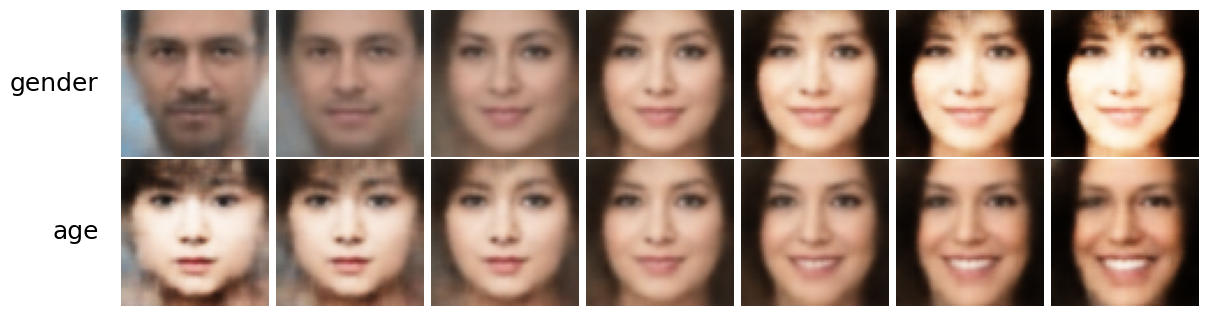

In [10]:
# Adjusting the weights of the first layer of the decoder to handle the rotated latent space
W_adjusted = np.dot(R.T, W)
decoder.layers[1].set_weights([W_adjusted, bias])

selected_attributes = ['gender','age']

# Latent traversal range
traversal_range = 5
steps = 7
linspace = np.linspace(-traversal_range, traversal_range, steps)

# Setup plot: 2 rows, tightly spaced
fig, axes = plt.subplots(2, steps, figsize=(14, 4),
                         gridspec_kw={'wspace': 0.00, 'hspace': 0.01})

for dim in [0, 1]:
    for i, val in enumerate(linspace):
        z = Z_val_orth_rotated[3, :].copy()
        z[dim] += val

        z_tensor = np.expand_dims(z, axis=0)
        decoded_image = decoder.predict(z_tensor, verbose=0)[0]
        decoded_image = np.clip(decoded_image, 0, 1)

        ax = axes[dim, i]
        ax.imshow(decoded_image)
        ax.axis('off')

        if i == 0:
            ax.set_ylabel(f'Dim {dim}', fontsize=12, rotation=90, labelpad=10)

# Add attribute labels
for row in range(2):
    ax = axes[row, 0]
    ax.text(
        -0.15, 0.5,
        selected_attributes[row], 
        va='center', ha='right',
        fontsize=18, transform=ax.transAxes
    )

plt.subplots_adjust(wspace=0.01, hspace=0.05, top=0.85)
plt.savefig('vae_latent_space_traversal_utkface_orth.jpg')
plt.show()

# Latent space traversal (Oblique rotation)

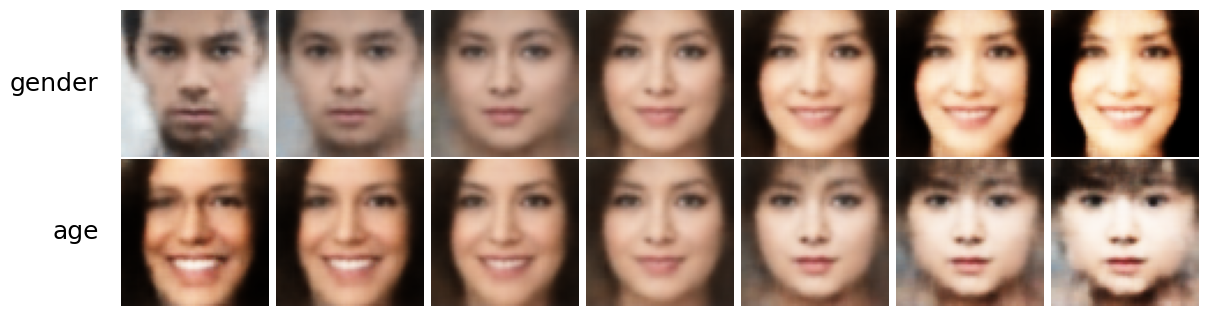

In [11]:
# Adjusting the weights of the first layer of the decoder to handle the rotated latent space
R_prime_inv = np.linalg.inv(R_prime)
W_adjusted = np.dot(R_prime_inv, W)
decoder.layers[1].set_weights([W_adjusted, bias])

selected_attributes = ['gender','age']

# Latent traversal range
traversal_range = 5
steps = 7
linspace = np.linspace(-traversal_range, traversal_range, steps)

# Setup plot: 2 rows, tightly spaced
fig, axes = plt.subplots(2, steps, figsize=(14, 4),
                         gridspec_kw={'wspace': 0.00, 'hspace': 0.01})

for dim in [0, 1]:
    for i, val in enumerate(linspace):
        z = Z_val_obl_rotated[3, :].copy()
        z[dim] += val

        z_tensor = np.expand_dims(z, axis=0)
        decoded_image = decoder.predict(z_tensor, verbose=0)[0]
        decoded_image = np.clip(decoded_image, 0, 1)

        ax = axes[dim, i]
        ax.imshow(decoded_image)
        ax.axis('off')

        if i == 0:
            ax.set_ylabel(f'Dim {dim}', fontsize=12, rotation=90, labelpad=10)

# Add attribute labels
for row in range(2):
    ax = axes[row, 0]
    ax.text(
        -0.15, 0.5,
        selected_attributes[row], 
        va='center', ha='right',
        fontsize=18, transform=ax.transAxes
    )

plt.subplots_adjust(wspace=0.01, hspace=0.05, top=0.85)
plt.savefig('vae_latent_space_traversal_utkface_obl.jpg')
plt.show()